In [1]:
!pip install git+https://github.com/facebookresearch/esm.git -q

In [2]:
import numpy as np
import pandas as pd
import torch
import esm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas()
import gc

In [3]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [4]:
if torch.cuda.is_available():
    model = model.cuda()
    print("Transferred model to GPU")

Transferred model to GPU


In [5]:
df = pd.read_csv('all_enzymes.csv')

## Use apply

In [6]:
def get_feature(r):
    data = [('protein',r.protein_sequence)]
    labels, strs, tokens = batch_converter(data)
    with torch.no_grad(): 
        results = model(tokens.cuda(), repr_layers=[33], return_contacts=True)
    rpr = results["representations"][33].squeeze()
    rpr=rpr[1 : len(r.protein_sequence) + 1].mean(0).detach().cpu().numpy()
    
    del results, labels, strs, tokens, data #especially need to delete those on cuda: tokens, results
    
    return rpr

In [11]:
!nvidia-smi #check Memory-Usage

Tue Nov 15 21:14:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                   0* |
| N/A   45C    P0    89W / 500W |  68033MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
def get_feature_df(df):
    series = df.progress_apply(get_feature, axis=1)
    df_feature = pd.DataFrame(series.tolist())
    return df_feature

In [60]:
df['len'] = df.protein_sequence.apply(len)

In [65]:
df2 = df.sort_values(by='len', ascending=False).iloc[17:]

In [67]:
df_feature = get_feature_df(df2)

  0%|          | 0/6591 [00:00<?, ?it/s]

In [72]:
df2

,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,split,len
4107,20930,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,51.6,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
4103,20926,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,45.4,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
4102,20925,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,60.2,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
4101,20924,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,57.7,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
4109,20932,MPVRRGHVAPQNTFLDTIIRKFEGQSRKLIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,51.8,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
...,...,...,...,...,...,...,...,...,...,...
3215,13940,MKGMAKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,57.5,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53
3214,13909,MKGASKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,59.2,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53
3213,13586,MKAMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,58.1,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53
3212,4618,MAGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,58.7,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53


In [71]:
len(df_feature)

6591

In [79]:
df2

,index,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,split,len
0,4107,20930,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,51.6,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
1,4103,20926,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,45.4,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
2,4102,20925,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,60.2,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
3,4101,20924,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,57.7,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
4,4109,20932,MPVRRGHVAPQNTFLDTIIRKFEGQSRKLIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,51.8,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,train,1159
...,...,...,...,...,...,...,...,...,...,...,...
6586,3215,13940,MKGMAKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,57.5,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53
6587,3214,13909,MKGASKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,59.2,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53
6588,3213,13586,MKAMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,58.1,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53
6589,3212,4618,MAGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,10.1038/nsb0894-518,58.7,53.0,25.0,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,train,53


In [83]:
df2.reset_index(inplace=True) #make sure the index of two concat dfs are same
df_combine = pd.concat([df2, df_feature], axis=1)

In [84]:
df_combine.head()

,level_0,index,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0,4107,20930,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,51.6,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,...,0.031775,-0.031993,-0.104209,0.057127,-0.052359,-0.003870,-0.019295,-0.056855,0.027195,0.079772
1,1,4103,20926,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,45.4,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,...,0.030997,-0.033303,-0.103292,0.056217,-0.052639,-0.004553,-0.019764,-0.058243,0.027680,0.081486
2,2,4102,20925,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,60.2,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,...,0.031284,-0.034017,-0.101006,0.056126,-0.052612,-0.002814,-0.019347,-0.058032,0.027677,0.080875
3,3,4101,20924,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,57.7,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,...,0.030985,-0.032532,-0.103684,0.054506,-0.052623,-0.003652,-0.019665,-0.057412,0.027688,0.080774
4,4,4109,20932,MPVRRGHVAPQNTFLDTIIRKFEGQSRKLIIANARVENCAVIYCND...,8.0,10.1371/journal.pone.0032654,51.8,1159.0,65.0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,...,0.030114,-0.033987,-0.104270,0.057183,-0.052627,-0.002089,-0.022006,-0.059038,0.026654,0.080276


In [115]:
len(df_combine)

6591

In [103]:
df_combine.to_csv('all_enzymes_feature.csv', index=False)

In [57]:
gc.collect();torch.cuda.empty_cache()

# Get WT feature

In [89]:
df_wt = pd.DataFrame(df2.wildtype.unique())

In [94]:
df_wt.rename(columns={0: 'protein_sequence'},inplace=True)

In [95]:
wt_feature = get_feature_df(df_wt)

  0%|          | 0/78 [00:00<?, ?it/s]

In [99]:
wt_combine = pd.concat([df_wt, wt_feature], axis=1)

In [102]:
wt_combine.to_csv('wildtype_feature.csv', index=False)

# Get WT-mutant differences

In [112]:
wt_combine.head()

,protein_sequence,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
1,MEELQDDYEDMMEENLEQEEYEDPDIPESQMEEPAAHDTEATATDY...,-0.017728,0.002291,-0.005282,-0.005080,-0.027136,-0.036133,0.065131,0.004717,0.007467,...,0.056245,0.033457,-0.124666,-0.020386,0.027567,-0.074638,0.048811,-0.047698,0.007801,0.049899
2,MTDITANVVVSNPRPIFTESRSFKAVANGKIYIGQIDTDPVNPANQ...,0.016938,0.050288,0.001779,-0.010340,-0.100914,0.016280,0.007097,-0.068371,0.050936,...,0.037742,-0.022452,0.080056,0.028671,0.020483,0.058210,0.075229,-0.084503,0.046309,0.086032
3,MSSRKELANAIRALSMDAVQKAKSGHPGAPMGMADIAEVLWRDFLK...,-0.011090,0.016666,-0.012930,0.030634,-0.012921,-0.012898,0.045492,-0.175886,0.034107,...,-0.067271,-0.067047,-0.062890,-0.037578,-0.029985,0.007193,0.019816,-0.198807,-0.022456,0.110925
4,MRPSLPPLLTCLLAALPALLSAGCSPATPSAHAAEPASRNVPFPYA...,-0.005208,-0.068409,0.039885,-0.062333,0.012764,-0.049863,0.015773,-0.156441,-0.020250,...,-0.021826,-0.072720,-0.002612,-0.078776,-0.078234,0.016206,0.081448,-0.206387,0.055972,0.011760


In [113]:
wt_combine.rename(columns={'protein_sequence': 'wildtype'},inplace=True)

In [117]:
all_enzymes_wildtype_feature = df_combine[['wildtype']].merge(wt_combine)

In [119]:
all_enzymes_wildtype_feature.to_csv('all_enzymes_wildtype_feature.csv', index=False)

# Get WT-mutant differences

In [ ]:
# wt = pd.read_csv('all_enzymes_wildtype_feature.csv')
# df_combine = pd.read_csv('all_enzymes_feature')

In [124]:
wt = all_enzymes_wildtype_feature.iloc[:,1:]

In [133]:
mutant = df_combine.iloc[:,-1280:]

In [134]:
wt

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
1,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
2,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
3,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
4,0.015805,-0.033919,0.005356,-0.001142,-0.037829,-0.062076,0.034698,0.074689,0.025458,0.099601,...,0.031189,-0.033546,-0.103467,0.056230,-0.052916,-0.003619,-0.020674,-0.058185,0.027794,0.081028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6586,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6587,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6588,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469
6589,0.056222,-0.019059,0.034438,0.042787,-0.081775,0.047643,0.119286,-0.011242,-0.062220,-0.031445,...,0.063324,-0.103465,-0.039717,-0.029019,0.053409,-0.129892,0.118203,-0.196604,0.070822,0.114469


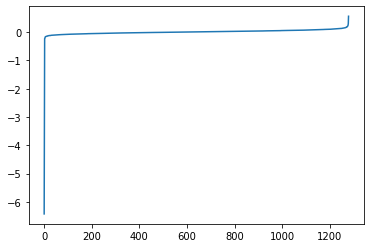

In [172]:
wt.iloc[1,:].sort_values().reset_index(drop=True).plot.line();

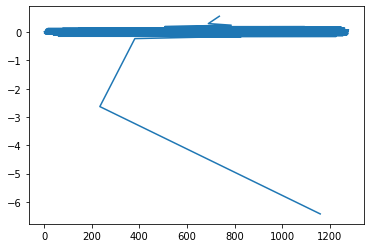

In [168]:
wt.iloc[1,:].sort_values().plot.line();

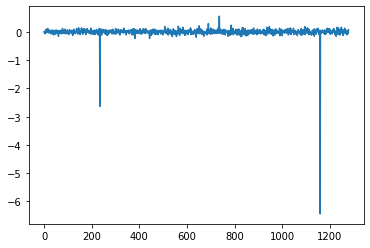

In [166]:
mutant.iloc[1,:].plot.line();

In [143]:
difference = (wt-mutant)*100

In [146]:
difference.sum(axis=1)

0       0.320376
1       0.481710
2       0.312745
3      -0.172836
4       0.414252
          ...   
6586    0.675470
6587    1.490860
6588   -4.357233
6589   -2.425898
6590   -2.844078
Length: 6591, dtype: float32

In [147]:
df_combine['difference'] = difference.sum(axis=1)

In [152]:
sub = df_combine.query('split == "test"')[['seq_id','difference']]

In [154]:
sub.reset_index(inplace=True,drop=True)

In [158]:
sub.rename(columns ={'difference':'tm'}, inplace=True)

In [160]:
sub.to_csv('submission.csv', index=False)

In [161]:
len(sub)

2413